In [2]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats
# Visualization
import matplotlib.pyplot as plt
import datetime
import os 

# os.system("pip install wrds") # TODO: Probably put this in utils.py
import wrds
# os.system("pip install pandas-datareader")
import pandas_datareader.data as web
import yfinance as yf
# os.system("pip install seaborn")
import seaborn as sns
import tqdm
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.tseries.offsets import BDay
from datetime import date

from typing import Tuple, List
# Note we don't actually need pandas_datareader. Could import/use YahooFinanceAPI which gives same info

In [3]:
df = pd.read_csv("../data/stock_indicators.csv")

In [4]:
date_cols= ["Date Became Aware of Breach", "Date of Disclosure"]
df[date_cols] = df[date_cols].apply(lambda x: pd.to_datetime(x, errors="coerce"))


In [5]:
df = df.dropna(subset=['Ticker'])

In [6]:
print("Date of Disclosure NAs: ", df["Date of Disclosure"].isna().sum())
print("Ticker NAs: ", df["Ticker"].isna().sum()) 

Date of Disclosure NAs:  0
Ticker NAs:  0


In [7]:
# Fix Ticker substocks
df["Ticker"] = df["Ticker"].apply(lambda x: x.replace(".", "-"))

In [8]:
df.head(50)

,Unnamed: 0,Company name,Ticker,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Information,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD),Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD),median stock forecast,mean stock forecast,count stock forecast,Financial (Type of Info),Intrusion (Type of Info),ND (Type of Info),Other (Type of Info),Personal (Type of Info),Exploit (Attack),Forged Cookies (Attack),Malware (Attack),Misconfiguration (Attack),ND (Attack),Phishing (Attack),Ransomware (Attack),SQLi (Attack),Spoofing (Attack),Unauthorized Access (Attack),Virus (Attack),rootkit (Attack),Construction (Industry),"Finance, Insurance, Real Estate (Industry)",Manufacturing (Industry),Mining (Industry),N/A (Industry),Retail Trade (Industry),Services (Industry),Transportation & Public Utilities (Industry),Wholesale Trade (Industry),Canada (Region),Foreign (Region),US Mid Atlantic (Region),US Midwest (Region),US New England (Region),US Southeast (Region),US Southwest (Region),US West (Region)
0,0,HUMANA INC,HUM,10/12/2020 - 12/16/2020,2020-12-22,2021-02-25,NaN,SSN | Name | DoB | Address | Phone Number | Em...,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,HERBALIFE NUTRITION LTD.,HLF,2020-10-01 00:00:00,NaT,2021-02-23,NaN,Name | Phone Number | Address | DOB | Membersh...,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,2,"Ultra Clean Holdings, Inc.",UCTT,NaN,NaT,2021-02-23,NaN,SSN | Driver's License,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,KROGER CO,KR,NaN,2021-01-23,2021-02-19,NaN,Name | Email | Phone Number | Address | DOB | ...,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,4,CINTAS CORP,CTAS,9/16/2020 - 9/20/2020,2020-09-20,2021-02-15,NaN,Name | Bank Account,345.100006,351.600006,350.079987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,5,"Blueknight Energy Partners, L.P.",BKEP,NaN,2021-01-12,2021-02-12,NaN,Name | SSN | Bank Account | Other,2.120000,3.120000,3.170000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
6,6,SOUTH JERSEY INDUSTRIES INC,SJI,NaN,NaT,2021-02-11,NaN,SSN | Account Number,23.480000,28.799999,24.620001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
7,7,"Globalstar, Inc.",GSAT,NaN,NaT,2021-02-10,NaN,Account Number,2.080000,1.590000,1.330000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
8,8,WestRock Co,WRK,NaN,2021-01-23,2021-02-08,NaN,ND,42.720001,53.180000,52.790001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,9,CARVANA CO.,CVNA,NaN,NaT,2021-02-05,NaN,Driver's License,284.529999,269.989990,267.329987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [9]:
max_normal_range = 1000
max_event_range = 10

earliest_breach_date = min(df["Date of Disclosure"])
latest_breach_date = max(df["Date of Disclosure"])
sp_start = earliest_breach_date - pd.to_timedelta(max_normal_range, unit="D")
sp_end = date.today()

In [10]:
sp500 = yf.download("^GSPC", start=sp_start, end=sp_end)

[*********************100%***********************]  1 of 1 completed


In [11]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-06-12,1013.260010,1021.849976,1002.580017,1020.260010,1020.260010,1795720000
2002-06-13,1020.260010,1023.469971,1008.119995,1009.559998,1009.559998,1405500000
2002-06-14,1009.559998,1009.559998,981.630005,1007.270020,1007.270020,1549000000
2002-06-17,1007.270020,1036.170044,1007.270020,1036.170044,1036.170044,1236600000
2002-06-18,1036.170044,1040.829956,1030.920044,1037.140015,1037.140015,1193100000


<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

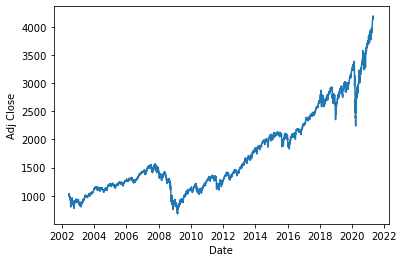

In [12]:
sns.lineplot(data=sp500, x="Date", y="Adj Close")

In [13]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [14]:
def window_date(date: datetime.datetime, window=(0, 0), business=True):
    if business:
        return (
            date + BDay(window[0]), 
            date + BDay(window[1])
        )
    return (
        date + pd.to_timedelta(window[0], unit="D"), 
        date + pd.to_timedelta(window[1], unit="D")
    )

def date_range(df, window_dates: Tuple[datetime.datetime, datetime.datetime]):
    return df.loc[(df.index >= window_dates[0]) & (df.index <= window_dates[1])]

def market_model(stock, sp500, window_date):
    # Normal Model Estimation
    window_sp500 = date_range(sp500, window_date)
    window_stock = date_range(stock, window_date)
    
    # pct_change - first entry is always nan
    sp500_returns = window_sp500["Adj Close"].pct_change()[1:].values.reshape(-1, 1) # "X"
    stock_returns = window_stock["Adj Close"].pct_change()[1:].values.reshape(-1, 1) # "Y"
    
    joined = pd.DataFrame({
        "sp500": window_sp500["Adj Close"], 
        "stock": window_stock["Adj Close"], 
    })
    if joined.isnull().values.any():
        print("Missing values for regression")
        
    joined = joined.dropna()
    
    if len(joined) == 0:
        raise ValueError("No stock values available. Ticker not available?")
        
    joined["sp500_returns"] = joined["sp500"].pct_change()
    joined["stock_returns"] = joined["stock"].pct_change()
    
    sp500_returns = joined["sp500_returns"].values[1:].reshape(-1, 1)
    stock_returns = joined["stock_returns"].values[1:].reshape(-1, 1)
    # Join the returns
    reg = LinearRegression()
    try:
        reg.fit(
            sp500_returns, 
            stock_returns
        )
        (alpha, beta) = reg.intercept_.item(), reg.coef_.item()
    except Exception as e:
#         print("<=========================== [Regression Error] ===========================>")
#         print(sp500_returns.shape)
#         print(stock_returns.shape)
#         print(joined.head())
#         print("<=========================== [Regression Error] ===========================>")
        raise ValueError("Model failed to fit")
    
    stock_returns_pred = reg.predict(sp500_returns)
    
    mse = mean_squared_error(stock_returns, stock_returns_pred)
    r2 = r2_score(stock_returns, stock_returns_pred)
    
    # Reformatted
    sp_ret = sp500_returns.ravel()
    st_ret = stock_returns.ravel()
    sp_ret = np.insert(sp_ret, 0, np.nan)
    st_ret = np.insert(st_ret, 0, np.nan)

    dat = pd.DataFrame({
        "sp500": window_sp500["Adj Close"], 
        "window_stock": window_stock["Adj Close"], 
        "sp500_returns": sp_ret,
        "stock_returns": st_ret,
    }, index=window_sp500["Adj Close"].index)
    
    return {
        "alpha": alpha,
        "beta": beta,
        "mse": mse,
        "r2": r2,
        "data": dat
    }


In [15]:
window_date(datetime.datetime.today(), (-1, 1))

(Timestamp('2021-04-26 15:04:38.920728'),
 Timestamp('2021-04-28 15:04:38.920728'))

In [16]:
long = pd.date_range("2018-01-01", periods=10, freq="D")
short = pd.date_range("2018-01-01", periods=5, freq="D")
large = pd.Series(range(len(long)), index=long)
small = pd.Series(range(len(short)), index=short)

# large = pd.DataFrame({"large": large})
# small = pd.DataFrame({"small": small})
# large.join(small, how='outer')
d = pd.DataFrame({"large": large, "small": small})
d.dropna()

,large,small
2018-01-01,0,0.0
2018-01-02,1,1.0
2018-01-03,2,2.0
2018-01-04,3,3.0
2018-01-05,4,4.0


In [17]:
saves = {}

def normal_return_model(row, est_window=(-200, -7), event_window=(-7, 7), windows = [], coerce=True, debug=True):
    if est_window[0] > est_window[1] or event_window[0] > event_window[1]:
        raise ValueError("Invalid Window: Windows must be in form (a, b), a < b")
    if est_window[1] > event_window[0]:
        raise ValueError("Overlapping windows!")
        
    ticker = row["Ticker"]
    disclosure_date = row["Date of Disclosure"]
    
    # Convert windows to date windows
    est_window_date = window_date(disclosure_date, est_window)
    event_window_date = window_date(disclosure_date, event_window)
    
    start_date = est_window_date[0]
    end_date = event_window_date[1]
    
    # Ensure dates are valid
    today_date = datetime.date.today()
    if end_date > today_date:
        if coerce:
            end_date = today_date
        else:
            raise ValueError(
                f"Ending interval of {end_date.strftime('%Y-%m-%d')} is later than today {today_date.strftime('%Y-%m-%d')}"
            )
    
    if debug:
        print(f"Ticker: {row['Ticker']}")
        print(f"Date of Disclosure: {row['Date of Disclosure'].strftime('%Y-%m-%d')}")
        print(f"estimation window: {est_window_date}")
        print(f"event window: {event_window_date}")
    # Download
    
    try:
        with suppress_stdout():
            raw_prices = yf.download(ticker, start=start_date, end=end_date)
            
            
            raw_prices.dropna(axis = 0, how = 'all', inplace = True)
            if len(raw_prices) == 0:
                raise ValueError("Download Failed.")
    except Exception as e:
#         print(f"Ticker: {row['Ticker']}")
#         print(f"Date of Disclosure: {row['Date of Disclosure'].strftime('%Y-%m-%d')}")
#         print(f"estimation window: {est_window_date}")
#         print(f"event window: {event_window_date}")
#         traceback.print_exc()
        raise ValueError('Download Failed.')
        
    # Linear Regression
    try:
        results = market_model(raw_prices, sp500, est_window_date)
        saves["results"] = results
        alpha, beta = results["alpha"], results["beta"]
    except Exception as e:
#         print("Row #: ", i)
#         print("Ticker: ", row["Ticker"])
        raise ValueError('Model fit failed.')
        
    
    # Draw
    if debug:
        model_df = results["data"]
        saves["model_df"] = model_df
#         plt.scatter(model_df["sp500_returns"], model_df["stock_returns"], color='black')
#         plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)
    
    # Event interval
    event_df = pd.DataFrame()
    event_df["actual"] = date_range(raw_prices, event_window_date)["Adj Close"].pct_change()[1:]
    event_df["sp500"] = date_range(sp500, event_window_date)["Adj Close"].pct_change()[1:]
    event_df["normal"] = alpha + beta * event_df["sp500"]
    event_df["abnormal"] = event_df["actual"] - event_df["normal"]
    
    # Compute CARs
    
    CAR = {}
    for w in windows:
        dates = window_date(disclosure_date, w)
        CAR[w] = date_range(event_df["abnormal"], dates).sum()
#     print(event_df)
    
#     event_data = pd.concat(actual_returns, sp500_returns, axis=1) 
#     print(event_data)
    return {
        "market_model": results,
        "event_df": event_df,
        "CAR": CAR,
    }

normal_return_model(df.iloc[0], windows = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)], debug=False)


{'market_model': {'alpha': -0.001284162345006583,
  'beta': 0.7296611253742332,
  'mse': 0.0002460786922381916,
  'r2': 0.2188656264703921,
  'data':                   sp500  window_stock  sp500_returns  stock_returns
  Date                                                               
  2020-05-21  2948.510010    392.742981            NaN            NaN
  2020-05-22  2955.449951    391.908356       0.002354      -0.002125
  2020-05-26  2991.770020    394.551361       0.012289       0.006744
  2020-05-27  3036.129883    396.786987       0.014827       0.005666
  2020-05-28  3029.729980    401.228424      -0.002108       0.011194
  ...                 ...           ...            ...            ...
  2021-02-09  3911.229980    381.960236      -0.001114       0.011233
  2021-02-10  3909.879883    377.377808      -0.000345      -0.011997
  2021-02-11  3916.379883    380.562561       0.001662       0.008439
  2021-02-12  3934.830078    380.013458       0.004711      -0.001443
  2021-02-16

In [19]:
import traceback

CARs = []
windows = [(0, i) for i in range(5)]
windows.extend([(-i, 0) for i in range(5)])
windows.extend([(-i, i) for i in range(5)])
print(windows)
arr = []
raw_results = []
for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    try:
        result = normal_return_model(row, windows = windows, debug=False)
        car = result['CAR']
        obj = {
            'alpha': result['market_model']['alpha'],
            'beta': result['market_model']['beta']
        }
        obj.update({f'CAR{k}': v for k, v in car.items()})
        arr.append(obj)
        raw_results.append(result)
    except Exception as e:
#         print("<=============== Error ===============>")
#         print(f"Row #: {i}")
#         print(f"Ticker: {row['Ticker']}")
#         print("<================ End ================>")
#         traceback.print_exc()
        arr.append({})
        raw_results.append({})

assert len(arr) == len(df)
    



  0%|          | 0/737 [00:00<?, ?it/s]

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 0), (-1, 0), (-2, 0), (-3, 0), (-4, 0), (0, 0), (-1, 1), (-2, 2), (-3, 3), (-4, 4)]


  2%|▏         | 18/737 [00:03<02:30,  4.78it/s]

Missing values for regression


 11%|█         | 79/737 [00:17<02:40,  4.10it/s]

Missing values for regression


 15%|█▌        | 114/737 [00:26<01:59,  5.20it/s]

Missing values for regression


 53%|█████▎    | 389/737 [02:09<08:56,  1.54s/it]

Missing values for regression


 54%|█████▎    | 396/737 [02:14<04:44,  1.20it/s]

Missing values for regression


 80%|████████  | 591/737 [05:48<01:58,  1.23it/s]

Missing values for regression


 81%|████████  | 594/737 [05:50<01:34,  1.51it/s]

Missing values for regression


 85%|████████▍ | 626/737 [06:25<01:35,  1.16it/s]

Missing values for regression


 91%|█████████ | 667/737 [07:10<01:11,  1.03s/it]

Missing values for regression


 94%|█████████▍| 694/737 [07:42<00:45,  1.06s/it]

Missing values for regression


 95%|█████████▍| 699/737 [07:49<00:48,  1.27s/it]

Missing values for regression


 95%|█████████▍| 700/737 [07:50<00:40,  1.10s/it]

Missing values for regression


 97%|█████████▋| 718/737 [08:09<00:18,  1.01it/s]

Missing values for regression


100%|██████████| 737/737 [08:29<00:00,  1.45it/s]


In [20]:
data_df = pd.DataFrame(arr)
data_df.head(50)
data_df.to_csv("../data/car_window_multi.csv")

In [24]:
import pickle
pkl_path = "../data/raw_results.pkl"

pickle.dump(raw_results, open(pkl_path , "wb"))

In [27]:
raw_results = pickle.load(open(pkl_path , "rb"))

In [33]:
result_df = df.copy()

In [37]:
pd.concat((result_df, data_df), axis=1).head()

,Unnamed: 0,Company name,Ticker,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Information,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD),Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD),median stock forecast,mean stock forecast,count stock forecast,Financial (Type of Info),Intrusion (Type of Info),ND (Type of Info),Other (Type of Info),Personal (Type of Info),Exploit (Attack),Forged Cookies (Attack),Malware (Attack),Misconfiguration (Attack),ND (Attack),Phishing (Attack),Ransomware (Attack),SQLi (Attack),Spoofing (Attack),Unauthorized Access (Attack),Virus (Attack),rootkit (Attack),Construction (Industry),"Finance, Insurance, Real Estate (Industry)",Manufacturing (Industry),Mining (Industry),N/A (Industry),Retail Trade (Industry),Services (Industry),Transportation & Public Utilities (Industry),Wholesale Trade (Industry),Canada (Region),Foreign (Region),US Mid Atlantic (Region),US Midwest (Region),US New England (Region),US Southeast (Region),US Southwest (Region),US West (Region),alpha,beta,"CAR(0, 0)","CAR(0, 1)","CAR(0, 2)","CAR(0, 3)","CAR(0, 4)","CAR(-1, 0)","CAR(-2, 0)","CAR(-3, 0)","CAR(-4, 0)","CAR(-1, 1)","CAR(-2, 2)","CAR(-3, 3)","CAR(-4, 4)"
0,0.0,HUMANA INC,HUM,10/12/2020 - 12/16/2020,2020-12-22,2021-02-25,NaN,SSN | Name | DoB | Address | Phone Number | Em...,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.001284,0.729661,0.017022,0.019302,0.017108,0.027874,0.029140,0.018244,0.014400,0.029233,0.028117,0.020525,0.014486,0.040085,0.040235
1,1.0,HERBALIFE NUTRITION LTD.,HLF,2020-10-01 00:00:00,NaT,2021-02-23,NaN,Name | Phone Number | Address | DOB | Membersh...,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000552,0.627575,0.004401,-0.005910,-0.005190,0.001705,-0.003996,-0.054406,-0.083507,-0.183648,-0.186695,-0.064717,-0.093099,-0.186345,-0.195093
2,2.0,"Ultra Clean Holdings, Inc.",UCTT,NaN,NaT,2021-02-23,NaN,SSN | Driver's License,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.003177,1.406970,-0.041744,-0.004872,-0.064055,-0.024123,0.032155,-0.082999,-0.033173,-0.074919,-0.089921,-0.046126,-0.055484,-0.057299,-0.016022
3,3.0,KROGER CO,KR,NaN,2021-01-23,2021-02-19,NaN,Name | Email | Phone Number | Address | DOB | ...,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000393,0.006037,0.004938,-0.008048,-0.025120,-0.034058,-0.044685,-0.010849,0.009854,0.000922,0.000922,-0.023835,-0.020204,-0.038074,-0.048700
4,4.0,CINTAS CORP,CTAS,9/16/2020 - 9/20/2020,2020-09-20,2021-02-15,NaN,Name | Bank Account,345.100006,351.600006,350.079987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000799,1.244020,0.000000,0.007677,-0.010081,-0.001435,0.009003,-0.002613,-0.026126,-0.027469,-0.026339,0.005064,-0.036207,-0.028904,-0.017335


In [39]:
.head()

,sp500,window_stock,sp500_returns,stock_returns
Date,,,,
2020-05-21,2948.510010,392.742981,NaN,NaN
2020-05-22,2955.449951,391.908356,0.002354,-0.002125
2020-05-26,2991.770020,394.551361,0.012289,0.006744
2020-05-27,3036.129883,396.786987,0.014827,0.005666
2020-05-28,3029.729980,401.228424,-0.002108,0.011194


### Individual Company Analysis

In [264]:
# Find indexes by company name (Equifax)
# df.index[df['Ticker'] == 'EFX']
np.where(df['Ticker'] == 'EFX')

(array([409, 440, 583]),)

In [266]:
raw_results[0].keys()

dict_keys(['market_model', 'event_df', 'CAR'])

#### General Company Data

In [290]:
index = 409
market_model_data = raw_results[index]["market_model"]
model_df = market_model_data["data"]
alpha = market_model_data["alpha"]
beta = market_model_data["beta"]

company_name = df.iloc[index]["Company name"]
company_ticker = df.iloc[index]["Ticker"]
breach_date = df.iloc[index]["Date of Disclosure"]
event_df = raw_results[index]["event_df"]

print(f"i:{index} > {company_name} ({company_ticker}), breach date: {breach_date.date()}")
print(f"Market Model: Y = {alpha:.3f} + {beta:.3f} * X")
model_df.head()


i:409 > EQUIFAX INC (EFX), breach date: 2017-09-07
Market Model: Y = 0.001 + 0.963 * X


,sp500,window_stock,sp500_returns,stock_returns
Date,,,,
2016-12-01,2191.080078,106.114700,NaN,NaN
2016-12-02,2191.949951,108.483582,0.000397,0.022324
2016-12-05,2204.709961,108.768990,0.005821,0.002631
2016-12-06,2212.229980,107.979362,0.003411,-0.007260
2016-12-07,2241.350098,110.348251,0.013163,0.021938


#### Market Model Return History (Estimation)

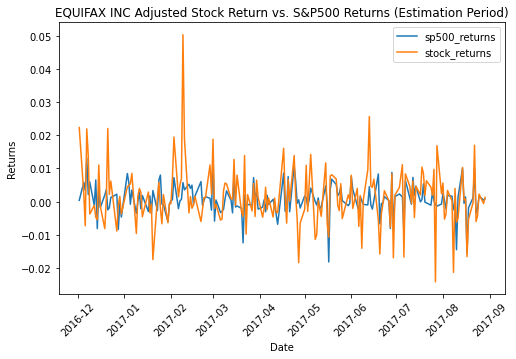

In [351]:
estimation_return = pd.melt(model_df[["sp500_returns", "stock_returns"]], ignore_index=False)
melted.head()

# filtered.tail(100)
plt.figure(figsize=(8,5))
ax = sns.lineplot(data=estimation_return, x=estimation_return.index, y="value", hue="variable")
ax.set_title(f"{company_name} Adjusted Stock Return vs. S&P500 Returns (Estimation Period)")
ax.set_ylabel("Returns")
plt.xticks(rotation=45)
ax.legend(loc=1)
plt.show()

Text(0.5, 0, 'S&P 500 Market Returns')

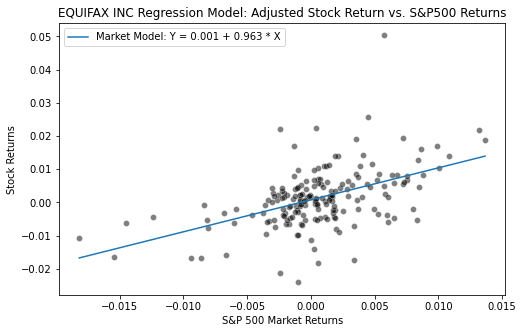

In [352]:
sp500_returns = model_df["sp500_returns"]
stock_returns = model_df["stock_returns"]

plt.figure(figsize=(8,5))
# Display regression line
X = sp500_returns.values
Y = alpha + beta * X
ax = sns.lineplot(x=X, y=Y, label=f'Market Model: Y = {alpha:.3f} + {beta:.3f} * X')
# ----------------------------
sns.scatterplot(data=model_df, x="sp500_returns", y="stock_returns", color="black", alpha=0.5)

ax.legend()
ax.set_title(f"{company_name} Regression Model: Adjusted Stock Return vs. S&P500 Returns")
ax.set_ylabel("Stock Returns")
ax.set_xlabel("S&P 500 Market Returns")

#### Event Analysis

In [353]:
diff = (pd.Series(event_df.index - breach_date, index = event_df.index))
event_df["day_diff"] = diff
event_df.head()

,actual,sp500,normal,abnormal,day_diff
Date,,,,,
2017-08-30,0.004404,0.004615,0.005204,-0.000800,-8 days
2017-08-31,0.007424,0.005721,0.006269,0.001155,-7 days
2017-09-01,-0.006176,0.001983,0.002667,-0.008844,-6 days
2017-09-05,-0.003461,-0.007551,-0.006517,0.003056,-2 days
2017-09-06,0.002055,0.003129,0.003772,-0.001716,-1 days


In [358]:
plt.figure(figsize=(8,5))
event_return = pd.melt(event_df[['sp500', 'actual']], ignore_index=False)


<Figure size 576x360 with 0 Axes>

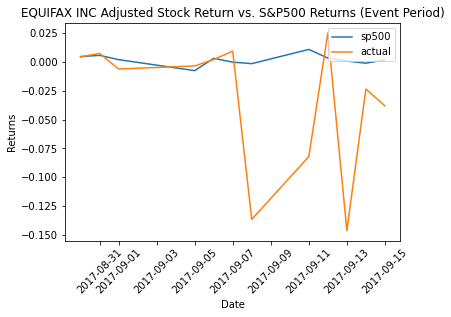

In [359]:
ax = sns.lineplot(data=event_return, x=event_return.index, y="value", hue="variable")
ax.set_title(f"{company_name} Adjusted Stock Return vs. S&P500 Returns (Event Period)")
ax.set_ylabel("Returns")
plt.xticks(rotation=45)
ax.legend(loc=1)
plt.show()

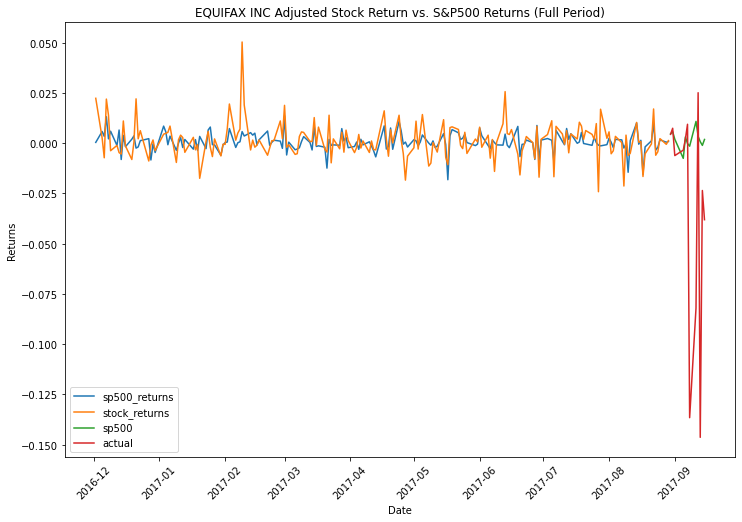

In [363]:
f = pd.concat([estimation_return, event_return], axis=0)

plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=f, x=f.index, y="value", hue="variable")
ax.set_title(f"{company_name} Adjusted Stock Return vs. S&P500 Returns (Full Period)")
ax.set_ylabel("Returns")
plt.xticks(rotation=45)
ax.legend(loc=3)
plt.show()

In [308]:
car_data = date_range(event_df, window_date(breach_date, CAR_range)) # Get the range of abnormal returns of interest
car_data.head()

,actual,sp500,normal,abnormal,day_diff
Date,,,,,
2017-09-07,0.009406,-0.000178,0.000585,0.008821,0 days
2017-09-08,-0.136561,-0.001489,-0.000677,-0.135884,1 days
2017-09-11,-0.082042,0.010839,0.011200,-0.093242,4 days
2017-09-12,0.025106,0.003364,0.003998,0.021108,5 days
2017-09-13,-0.146344,0.000757,0.001487,-0.147830,6 days


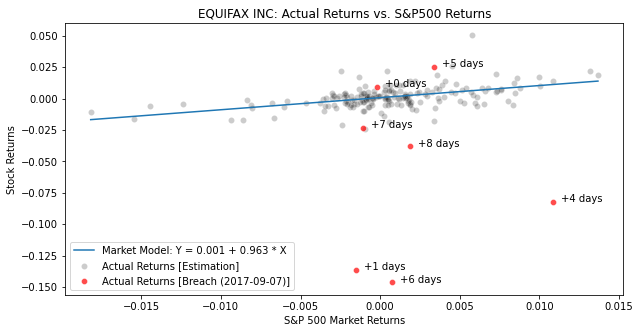

In [343]:
# Plotted with abnormal returns

plt.figure(figsize=(10,5))
ax = sns.lineplot(x=X, y=Y, label=f'Market Model: Y = {alpha:.3f} + {beta:.3f} * X')
sns.scatterplot(data=model_df, x="sp500_returns", y="stock_returns", color="black", alpha=0.2, label="Actual Returns [Estimation]")
sns.scatterplot(data=car_data, x="sp500", y="actual", color="red", alpha=0.7, label=f"Actual Returns [Breach ({breach_date.date()})]")
ax.legend(loc=3)
ax.set_title(f"{company_name}: Actual Returns vs. S&P500 Returns")
ax.set_ylabel("Stock Returns")
ax.set_xlabel("S&P 500 Market Returns")


for line in range(0,car_data.shape[0]):
     ax.text(car_data["sp500"][line] + 0.0005, car_data["actual"][line], 
     f"+{car_data['day_diff'][line].days} days", horizontalalignment='left', 
     size='medium', color='black')
        
plt.show()

### CAR Plots

In [126]:
data_df.describe()
# sns.histplot(data=data_df, x="CAR(0, 3)")

,alpha,beta,"CAR(0, 0)","CAR(0, 1)","CAR(0, 2)","CAR(0, 3)","CAR(0, 4)","CAR(-1, 0)","CAR(-2, 0)","CAR(-3, 0)","CAR(-4, 0)","CAR(-1, 1)","CAR(-2, 2)","CAR(-3, 3)","CAR(-4, 4)"
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,0.000053,1.023100,-0.002988,-0.005523,-0.005461,-0.005951,-0.005077,-0.003543,-0.005016,-0.006480,-0.005464,-0.006079,-0.007490,-0.009443,-0.007553
std,0.002481,0.406109,0.031683,0.051165,0.063268,0.076296,0.077086,0.051530,0.057690,0.067630,0.071852,0.067590,0.083621,0.100194,0.102354
min,-0.015719,-0.675626,-0.283234,-0.500287,-0.612629,-0.981688,-0.969539,-0.339825,-0.467816,-0.676899,-0.744292,-0.689882,-0.806871,-1.149207,-0.924367
25%,-0.000688,0.792516,-0.009730,-0.015455,-0.017480,-0.020186,-0.021391,-0.013725,-0.018967,-0.021282,-0.022933,-0.019143,-0.025747,-0.029474,-0.031421
50%,0.000077,1.012842,-0.001301,-0.001397,-0.001998,-0.001914,-0.000498,-0.001707,-0.002375,-0.002215,-0.003452,-0.001759,-0.002515,-0.003207,-0.004596
75%,0.000810,1.245130,0.006023,0.009438,0.013467,0.015015,0.019075,0.010556,0.010965,0.015660,0.016742,0.012224,0.016889,0.021759,0.027082
max,0.045698,2.803848,0.178117,0.315104,0.568382,0.786172,0.602221,0.833082,0.864915,0.914935,0.908253,0.744021,0.883055,0.933075,0.859731


In [209]:
data_df.head()
data_df.columns

Index(['alpha', 'beta', 'CAR(0, 0)', 'CAR(0, 1)', 'CAR(0, 2)', 'CAR(0, 3)',
       'CAR(0, 4)', 'CAR(-1, 0)', 'CAR(-2, 0)', 'CAR(-3, 0)', 'CAR(-4, 0)',
       'CAR(-1, 1)', 'CAR(-2, 2)', 'CAR(-3, 3)', 'CAR(-4, 4)'],
      dtype='object')

In [210]:
post_car_columns = ['CAR(0, 0)', 'CAR(0, 1)', 'CAR(0, 2)', 'CAR(0, 3)', 'CAR(0, 4)']
pre_car_columns = ['CAR(-1, 0)', 'CAR(-2, 0)', 'CAR(-3, 0)', 'CAR(-4, 0)']
wide_car_columns = ['CAR(-1, 1)', 'CAR(-2, 2)', 'CAR(-3, 3)', 'CAR(-4, 4)']
post_car = data_df[post_car_columns]
pre_car = data_df[pre_car_columns]
wide_car = data_df[wide_car_columns]

<Figure size 432x360 with 0 Axes>

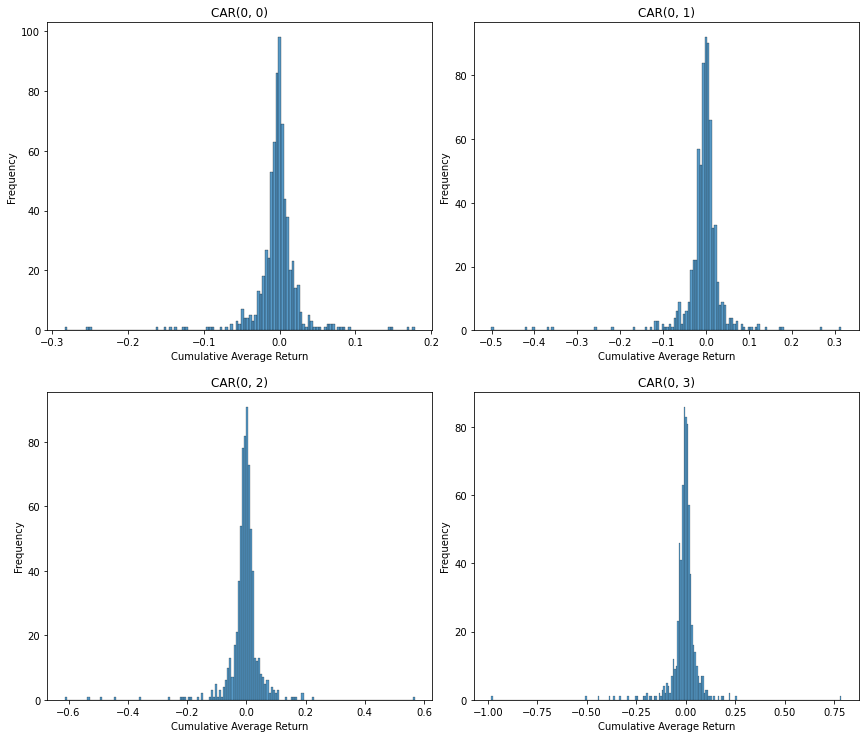

In [364]:
plt.figure(figsize=(6,5))

A = 2
B = 2
fig, axs = plt.subplots(A, B, figsize=(6 * A, 5 * B))
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)
for ax, col in zip(axs.flat, post_car_columns):
    ax = sns.histplot(data_df[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Cumulative Average Return")
    ax.set_ylabel("Frequency")
plt.show()

In [240]:
import scipy
f = pd.DataFrame({name: scipy.stats.ttest_1samp(data.dropna().values, 0) for (name, data) in post_car.iteritems()})
f.insert(0, 'Description', ["t-statistic", "p-value"])
f.head()

,Description,"CAR(0, 0)","CAR(0, 1)","CAR(0, 2)","CAR(0, 3)","CAR(0, 4)"
0,t-statistic,-2.496676,-2.858065,-2.285445,-2.065081,-1.743648
1,p-value,0.012765,0.004389,0.022585,0.039283,0.081659


In [234]:
{name: scipy.stats.ttest_1samp(data.dropna().values, 0) for (name, data) in post_car.iteritems()}

{'CAR(0, 0)': Ttest_1sampResult(statistic=-2.4966763846105864, pvalue=0.012765110304080349),
 'CAR(0, 1)': Ttest_1sampResult(statistic=-2.8580654163502506, pvalue=0.004388953890536081),
 'CAR(0, 2)': Ttest_1sampResult(statistic=-2.285444653004651, pvalue=0.0225849026795037),
 'CAR(0, 3)': Ttest_1sampResult(statistic=-2.0650810416001937, pvalue=0.03928298728076561),
 'CAR(0, 4)': Ttest_1sampResult(statistic=-1.7436480736939275, pvalue=0.08165947977566047)}

In [ ]:
new_df = pd.concat([result_df, data_df], axis=1)
new_df.head()

In [ ]:
tester = {}
tester[(0, 1)] = 1
tester

In [241]:
# pd.set_option("display.max_rows", None)

# display(sp500)
row = df.iloc[0]
disclosure_date = row["Date of Disclosure"]
print(disclosure_date)
event_window=(-3, 5)

window = window_date(disclosure_date, event_window)
print(window[0])
print(window[1])
adj_close = date_range(sp500, window)["Adj Close"]


2021-02-25 00:00:00
2021-02-22 00:00:00
2021-03-04 00:00:00


In [312]:
result_df["Number of Records"]

395